# Diorama single L1 TFA Inversion

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
import os
import pandas as pd

from fatiando.vis import mpl
from fatiando.utils import ang2vec
from fatiando.gravmag import polyprism

/home/leonardo/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [2]:
from datetime import date
today = date.today()
# dd/mm/YY
d4 = today.strftime("%b-%d-%Y")

### Auxiliary functions

In [3]:
import sys
sys.path.insert(0, '../../code')

import mag_polyprism_functions as mfun

# Input

### Importing Diorama TFA data

In [4]:
data = pd.read_csv('diorama_decimated_tfa_residual.txt', skipinitialspace=True, delim_whitespace=True)

In [5]:
data['GPSALT'] = data['GPSALT']

In [6]:
xp = data['X'].get_values()
yp = data['Y'].get_values()
zp = data['GPSALT'].get_values()
dobs = data['mag_res2'].get_values()

In [7]:
np.min(zp)

-337.79

### Parameters of the initial model

In [8]:
M = 20 # number of vertices per prism
L = 6 # number of prisms
P = L*(M+2) + 1 # number of parameters

#figura
incs = -46.
decs = 24.
intensity = 17.
props = {'magnetization': ang2vec(intensity, incs, decs)}

# depth to the top, thickness and radius
z0 = 250.
dz = 350.
r = 1200.

x0, y0 = [8212500., 478200.]

# main field
inc, dec = [-19.5, -18.]

rin = np.zeros(M) + r
m0 = np.hstack((rin, np.array([x0, y0])))
m0 = np.resize(m0, P - 1) # inicial parameters vector
m0 = np.hstack((m0, dz))
model0 = mfun.param2polyprism(m0, M, L, z0, props) # list of classes of prisms

# predict data
d0 = polyprism.tf(xp, yp, zp, model0, inc, dec)

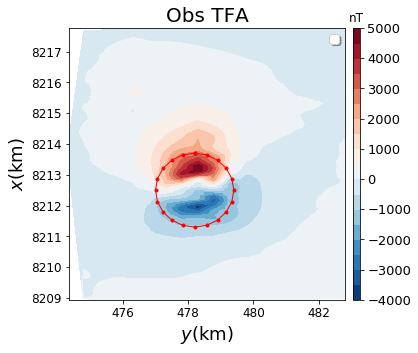

In [9]:
plt.figure(figsize=(6,5))
plt.title('Obs TFA', fontsize=20)
plt.tricontourf(yp, xp, dobs, 20, cmap='RdBu_r').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
estimate = mpl.polygon(model0[0], '.-r', xy2ne=True)
clb.ax.set_title('nT')
mpl.m2km()
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1)
plt.show()

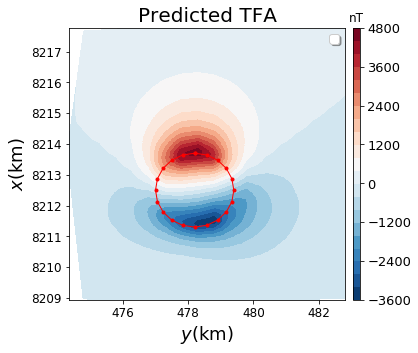

In [10]:
plt.figure(figsize=(6,5))
plt.title('Predicted TFA', fontsize=20)
plt.tricontourf(yp, xp, d0, 20, cmap='RdBu_r').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
estimate = mpl.polygon(model0[0], '.-r', xy2ne=True)
clb.ax.set_title('nT')
mpl.m2km()
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1)
plt.show()

### Limits

In [11]:
# limits for parameters in meters
rmin = 10.
rmax = 1500.
x0min = 8212500.
x0max = 8213500.
y0min = 478000.
y0max = 479000.
dzmin = 10.
dzmax = 1000.

mmin, mmax = mfun.build_range_param(M, L, rmin, rmax, x0min, x0max, y0min, y0max, dzmin, dzmax)

### Variation

In [12]:
# variation for derivatives
deltax = 0.01*np.max(100.)
deltay = 0.01*np.max(100.)
deltar = 0.01*np.max(100.)
deltaz = 0.01*np.max(100.)

### Outcropping parameters

In [13]:
# outcropping body parameters
m_out = np.zeros(M + 2)
#m_out = model['param_vec'][:M+2]

In [14]:
# output of inversion
inversion = dict()

### Regularization parameters

In [15]:
#lamb = th*0.01 # Marquadt's parameter
lamb = 10.0
dlamb = 10.      # step for Marquadt's parameter

a1 = 1.0e-5  # adjacent radial distances within each prism
a2 = 1.0e-4   # vertically adjacent radial distances
a3 = 0.     # outcropping cross-section
a4 = 0.     # outcropping origin
a5 = 1.0e-4    # vertically adjacent origins
a6 = 1.0e-8   # zero order Tikhonov on adjacent radial distances
a7 = 1.0e-7     # zero order Tikhonov on thickness of each prism

In [16]:
delta = np.array([deltax, deltay, deltar, deltaz])
alpha = np.array([a1, a2, a3, a4, a5, a6, a7])

In [17]:
itmax = 30
itmax_marq = 10
tol = 1.0e-4     # stop criterion

In [ ]:
foldername = ''

In [18]:
inversion['x'] = xp
inversion['y'] = yp
inversion['z'] = zp
inversion['observed_data'] = dobs

In [19]:
inversion['inc_dec'] = [incs, decs]
inversion['z0'] = z0
inversion['initial_dz'] = dz
inversion['intial_r'] = r
inversion['limits'] = [rmin, rmax, x0min, x0max, y0min, y0max, dzmin, dzmax]
inversion['regularization'] = np.array([a1, a2, a3, a4, a5, a6, a7])
inversion['tol'] = tol
inversion['main_field'] = [-21.5, -18.7]

### Inversion

In [20]:
d_fit, m_est, model_est, phi_list, model_list, res_list = mfun.l1_levmarq_tf(
    xp, yp, zp, m0, M, L, delta,
    itmax, itmax_marq, lamb,
    dlamb, tol, mmin, mmax,
    m_out, dobs, inc, dec,
    model0[0].props, alpha, z0, dz
)

it:  0   it_marq:  0   lambda: 1e+01   init obj.: 3.18649e+02  fin obj.: 2.66394e+02
it:  1   it_marq:  0   lambda: 1e+00   init obj.: 2.66394e+02  fin obj.: 2.20738e+02
it:  2   it_marq:  0   lambda: 1e-01   init obj.: 2.20738e+02  fin obj.: 2.59113e+02
it:  2   it_marq:  1   lambda: 1e+00   init obj.: 2.20738e+02  fin obj.: 1.46739e+02
it:  3   it_marq:  0   lambda: 1e-01   init obj.: 1.46739e+02  fin obj.: 3.57355e+02
it:  3   it_marq:  1   lambda: 1e+00   init obj.: 1.46739e+02  fin obj.: 3.58827e+02
it:  3   it_marq:  2   lambda: 1e+01   init obj.: 1.46739e+02  fin obj.: 3.74475e+02
it:  3   it_marq:  3   lambda: 1e+02   init obj.: 1.46739e+02  fin obj.: 2.79154e+02
it:  3   it_marq:  4   lambda: 1e+03   init obj.: 1.46739e+02  fin obj.: 1.46649e+02
it:  4   it_marq:  0   lambda: 1e+02   init obj.: 1.46649e+02  fin obj.: 1.45535e+02
it:  5   it_marq:  0   lambda: 1e+01   init obj.: 1.45535e+02  fin obj.: 1.38447e+02
it:  6   it_marq:  0   lambda: 1e+00   init obj.: 1.38447e+02  fi

# Results

In [21]:
inversion['data_fit'] = d_fit
inversion['estimate'] = m_est
inversion['prisms'] = model_est
inversion['estimated_models'] = model_list
inversion['objective'] = phi_list
inversion['residual'] = dobs - d_fit
inversion['residual_list'] = res_list
inversion['initial_estimate'] = model0

### Folder to save the results

In [ ]:
if foldername == '':
    mypath = 'l1-tfa-inversion/single-'+d4 #default folder name
    if not os.path.isdir(mypath):
       os.makedirs(mypath)
else:
    mypath = 'l1-tfa-inversion/single-'+foldername #defined folder name
    if not os.path.isdir(mypath):
       os.makedirs(mypath)

In [24]:
file_name = mypath+'/inversion.pickle'
with open(file_name, 'w') as f:
    pickle.dump(inversion, f)

In [25]:
mypath

'l1-tfa-inversion/single-Jul-30-2020'